In [1]:
pip install refl1d

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 218 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 752 kB 48.9 MB/s eta 0:00:01
     |████████████████████████████████| 542 kB 66.2 MB/s eta 0:00:01
  Created wheel for bumps: filename=bumps-0.9.1-py3-none-any.whl size=566601 sha256=a6952a5b6cb1776628fc7847368205eaf98902ba6a2632337d42fa9f0922095e
  Stored in directory: /home/shao.yut/.cache/pip/wheels/f4/7e/61/63488a4007e1f92b19d0bd9ec79f42439a68087f28aab4e73d
Successfully built bumps
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.6 MB 10.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 511 kB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 66.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 70.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 59.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import os
import math
import json
import numpy as np

import refl1d
from refl1d.names import *

#import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

In [2]:

from scipy.interpolate import CubicSpline


def calculate_reflectivity(q, model_description, q_resolution=0.0294855):
    """
        Reflectivity calculation using refl1d
    """
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    layers = model_description['layers']
    sample = Slab(material=SLD(name=layers[0]['name'],
                               rho=layers[0]['sld']), interface=layers[0]['roughness'])
    # Add each layer
    for l in layers[1:]:
        sample = sample | Slab(material=SLD(name=l['name'],
                               rho=l['sld'], irho=l['isld']),
                               thickness=l['thickness'], interface=l['roughness'])

    probe.background = Parameter(value=model_description['background'], name='background')
    expt = Experiment(probe=probe, sample=sample)

    q, r = expt.reflectivity()
    z, sld, _ = expt.smooth_profile()
    zNew = np.linspace(z[0], z[-1], num=1000)
    newCurve = CubicSpline(z, sld)
    sldNew = []
    for i in range(zNew.shape[0]):
      sldNew.append(newCurve(zNew[i]))
    return model_description['scale'] * r, zNew, sldNew


class ReflectivityModels(object):
    # Neutrons come in from the last item in the list
    model_description = dict(layers=[
                                dict(sld=2.07, isld=0, thickness=0, roughness=3, name='substrate'),
                                dict(sld=3.8, isld=0, thickness=16.2139, roughness=2, name='siox'),
                                dict(sld=1.45, isld=0, thickness=145.692, roughness=56.5063, name='bottom'),
                                dict(sld=5.37, isld=0, thickness=214.226, roughness=61.0084, name='bulk'),
                                dict(sld=3.66, isld=0, thickness=172.941, roughness=75.6358, name='top_layer'),
                                dict(sld=0, isld=0, thickness=50, roughness=0, name='air')
                         ],
                         scale=1,
                         background=0,
                        )
    parameters = [
                  dict(i=0, par='roughness', bounds=[0, 5]),
                  # The following is the Si oxide layer
                  dict(i=1, par='sld', bounds=[3.0, 3.9]),
                  dict(i=1, par='thickness', bounds=[10, 25]),
                  dict(i=1, par='roughness', bounds=[1, 10]),

                  # The next three layers are the polymer
                  dict(i=2, par='sld', bounds=[0, 6.4]),
                  dict(i=2, par='thickness', bounds=[20, 300]),
                  dict(i=2, par='roughness', bounds=[0, 20]),
                  dict(i=3, par='sld', bounds=[0, 6.4]),
                  dict(i=3, par='thickness', bounds=[20, 300]),
                  dict(i=3, par='roughness', bounds=[0, 20]),
                  dict(i=4, par='sld', bounds=[0, 6.4]),
                  dict(i=4, par='thickness', bounds=[20, 300]),
                  dict(i=4, par='roughness', bounds=[0, 20]),
                 ]

    _config_name = 'polymer'

    def __init__(self, q=None, name='polymer'):
        # The following are unmodified physical parameters and corresponding reflectivity data
        self._pars_array = []
        self._refl_array = []
        self._smooth_array = []
        # The following are the parameters, mapped between -1 and 1.
        self._train_pars = []
        self._train_data = None
        self._config_name = name

        if q is None:
            self.q = np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308)
        else:
            self.q = q

    @classmethod
    def from_dict(cls, pars, q_array=None):
        """
            Create ReflectivityModels object from a dict that
            defines the reflectivity model parameters and how
            the training set should be generated.
        """
        m = cls(q_array, name=pars['name'])
        m.model_description =  pars['model']
        m.parameters = pars['parameters']
        return m

    def generate(self, n=100):
        """
            Generate a random sample of models
        """
        npars = len(self.parameters)
        self._train_pars = np.random.uniform(low=-1, high=1, size=[n, npars])
        # Compute model parameters and reflectivity using these values
        self.compute_reflectivity()

    def to_model_parameters(self, pars):
        """
            Transform an array of parameters to a list of calculable models
        """
        pars_array = np.zeros(pars.shape)

        for i, par in enumerate(self.parameters):
            a = (par['bounds'][1]-par['bounds'][0])/2.
            b = (par['bounds'][1]+par['bounds'][0])/2.
            pars_array.T[i] = pars.T[i] * a + b

        return pars_array

    def compute_reflectivity(self):
        """
            Transform an array of parameters to a list of calculable models
            and compute reflectivity
        """
        print("Computing reflectivity")
        self._pars_array = self.to_model_parameters(self._train_pars)
        
        for p in self._pars_array:
            _desc = self.get_model_description(p)
            r, z, sld = calculate_reflectivity(self.q, _desc)
            
            self._refl_array.append(r)
            self._smooth_array.append([z,sld])

    def get_model_description(self, pars):
        """
            Convert the parameter list to a model description that we can use
            to compute R(q).
        """
        for i, par in enumerate(self.parameters):
            self.model_description['layers'][par['i']][par['par']] = pars[i]
        return self.model_description

    def get_preprocessed_data(self, errors=None):
        """
            Pre-process data
            If errors is provided, a random error will be added, taking the errors array
            as a relative uncertainty.
        """
        if errors is None:

            self._train_data = np.log10(self._refl_array*self.q**2/self.q[0]**2)
        else:
            _data = self._refl_array * (1.0 + np.random.normal(size=len(errors)) * errors)
            # Catch the few cases where we generated a negative intensity and take
            # the absolute value
            _data[_data<0] = np.fabs(_data[_data<0])
            self._train_data = np.log10(_data*self.q**2/self.q[0]**2)

        return self._train_pars, self._train_data

    def save(self, output_dir=''):
        """
            Save all data relevant to a training set
            @param output_dir: directory used to store training sets
        """
        # Save q values
        np.save(os.path.join(output_dir, "%s_q_values" % self._config_name), self.q)

        # Save training set
        if self._train_data is not None:
            np.save(os.path.join(output_dir, "%s_data" % self._config_name), self._train_data)
            np.save(os.path.join(output_dir, "%s_pars" % self._config_name), self._train_pars)

    def load(self, data_dir=''):
        self.q = np.load(os.path.join(data_dir, "%s_q_values.npy" % self._config_name))
        self._train_data = np.load(os.path.join(data_dir, "%s_data.npy" % self._config_name))
        self._train_pars = np.load(os.path.join(data_dir, "%s_pars.npy" % self._config_name))
        return self.q, self._train_data, self._train_pars


Modify the `ReflectivityModels` class to simulate time-resolved reflectivity data by allowing the thickness of certain layers to change with time

In [9]:
class TimeResolvedReflectivityModels(ReflectivityModels):
    def generate_time_resolved(self, n=1, time_points=10):
        """
        Generate time-resolved reflectivity data.
        This is an example where we simulate the growth of the 'top_layer' over time.
        """
        npars = len(self.parameters)
        self._train_pars = np.random.uniform(low=-1, high=1, size=[n, npars])
        for i in range(time_points):
            self._train_pars[0][-2] += 0.05
            self.compute_reflectivity()



In [10]:
model = TimeResolvedReflectivityModels()
model.generate_time_resolved(n=1, time_points=10)


Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity
Computing reflectivity


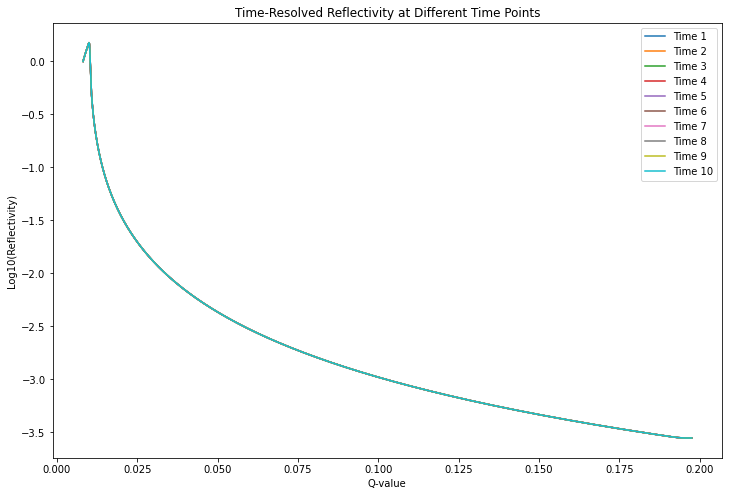

In [4]:
# NOTE: Here I would pass the q-array of the time-resolved data when instantiating this object.
m = ReflectivityModels()

# Generate 100 curves
m.generate(40)

# The following will return the pre-processed parameterts and R(q) data.



Computing reflectivity


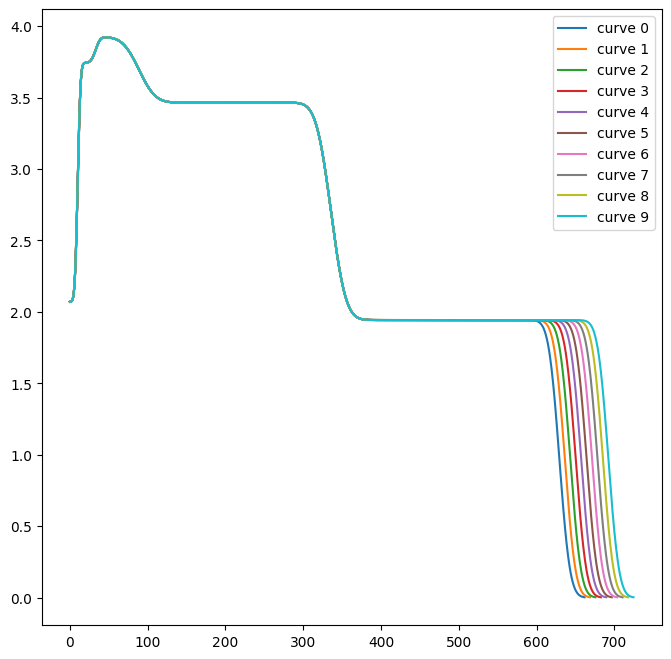

In [14]:
m = model
pars, train_data = m.get_preprocessed_data()


fig = plt.figure(dpi=100, figsize=[8,8])
# Let's look at a few curves
min_x = float('inf')
max_x = -float('inf')
for index in range(len(m._smooth_array)):
  min_x = min(m._smooth_array[index][0])
  for i in range(len(m._smooth_array[index][0])):
    m._smooth_array[index][0][i] -= min_x
for index in range(len(m._smooth_array)):
    plt.plot(m._smooth_array[index][0], m._smooth_array[index][1], label='curve %d' % index)
plt.legend()
plt.show()

In [15]:
settingUp = []
SLDSet = []
for i in range(len(m._smooth_array)):
  settingUp.append(np.array([m.q,m._refl_array[i]]))
  SLDSet.append(np.array(m._smooth_array[i]))
  # print(np.array(m._smooth_array[i]).shape)

totalStack = np.stack(settingUp)
totalParams = np.stack(SLDSet)
print(totalStack.shape, totalParams.shape)
np.save("SLD_CurvesSAME2DExperimentXPOINTS2.npy", totalParams)
np.save("NR-SLD_CurvesSAME2DExperimentXPOINTS2.npy", totalStack)

(10, 2, 308) (10, 2, 1000)


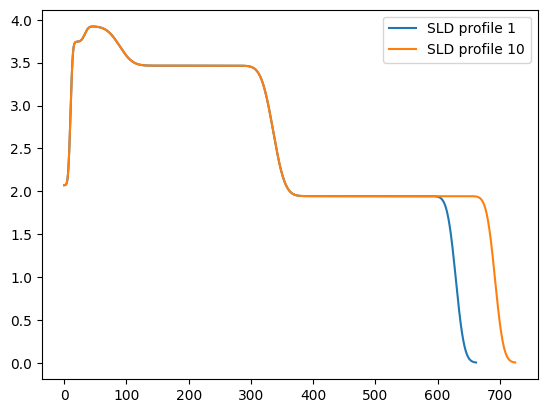

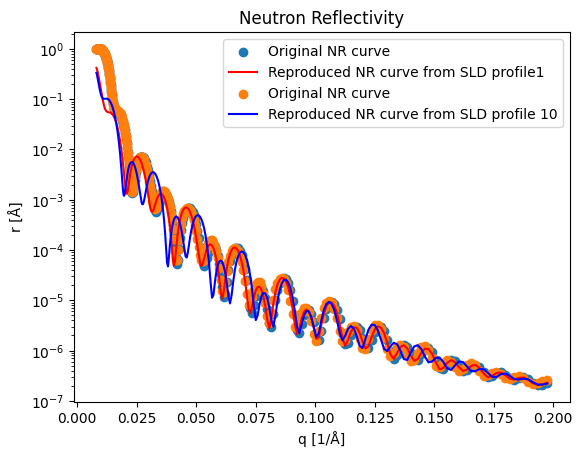

In [18]:
def calculate_reflectivity_from_profile(q, z_step, sld, q_resolution=0.0294855):

    """

        Reflectivity calculation using refl1d from an array of microslabs

    """

    sld = np.flip(sld)
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355
    # The QProbe object represents the beam

    probe = QProbe(q, dq, data=(zeros, zeros))
    sample = Slab(material=SLD(name='back', rho=sld[0], irho=0), interface=0)
    # Add each layer
    _prev_z = z_step[0]
    for i, _sld in enumerate(sld):
        if i>0:
            thickness = z_step[i] - _prev_z
            sample = sample | Slab(material=SLD(name='l_%d' % i, rho=_sld, irho=0),
                                                thickness=thickness,
                                                interface=0)
        _prev_z = z_step[i]
    probe.background = Parameter(value=0, name='background')
    expt = Experiment(probe=probe, sample=sample)
    a, r = expt.reflectivity()
    return a, r
z, sld = m._smooth_array[0][0], m._smooth_array[0][1]
plt.plot(z, sld, label = "SLD profile 1")
z1, sld1 = m._smooth_array[9][0], m._smooth_array[9][1]
plt.plot(z1, sld1, label = "SLD profile 10")
plt.legend()
plt.show()

a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z, sld)
a1, r1 = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z1, sld1)

plt.scatter(m.q,m._refl_array[0], label = "Original NR curve")
plt.plot(m.q,r, label = "Reproduced NR curve from SLD profile1", c='r')
plt.scatter(m.q,m._refl_array[1], label = "Original NR curve")
plt.plot(m.q,r1, label = "Reproduced NR curve from SLD profile 10", c='b')
plt.legend()
# plt.xscale("log")
plt.xlabel("q [1/Å]")
plt.ylabel("r [Å]")
plt.title("Neutron Reflectivity")

plt.yscale("log")
plt.savefig('Example SLD to NR')
# print(data)
plt.show()
# print("h9i")

In [8]:
z, sld = np.load("File 202413_2d (3).npy")
plt.style.use("seaborn-darkgrid")
plt.plot(z, sld, linewidth=4, color="g")
plt.xlabel("z [Å]")
plt.ylabel("SLD [$10^{-6}Å^{-2}$]")
plt.title("Scattering Length Density Profile")
plt.savefig('202413 SLD Graph.jpeg')

plt.show()
a, r = calculate_reflectivity_from_profile(np.logspace(np.log10(0.008101436040354381), np.log10(0.1975709062238298), num=308), z, sld)
other = np.load("./Neutron_Reflect/npoutputsPoly/np_out_REFL_202413_combined_data_auto.npy")
# plt.plot(m.q,)
yPoints = []
for i in range(len(other)):
    yPoints.append(other[i][1])
plt.plot(m.q,r, linewidth=2, color='r', label="Reproduced NR curve from SLD profile")
plt.scatter(m.q, yPoints, linewidth=0.01, label="Original Experimental NR curve")
# plt.xscale("log")
plt.xlabel("q [1/Å]")
plt.ylabel("r [Å]")
plt.title("Neutron Reflectivity")
plt.yscale("log")
plt.legend()
# print(data)
plt.savefig('202413 Neutron Reflectivity Graph.jpeg')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'File 202413_2d (3).npy'